In [ ]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install -q numpy==1.20.0
!pip install -q cellpose 
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import os
import glob
from tqdm.auto import tqdm
import tifffile
import matplotlib.pyplot as plt
import random

In [2]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    
fix_all_seeds(2021)

## Visualising Flows
#### 5-fold data Generated in cellpose format here: https://www.kaggle.com/ks2019/sartorius-train-tif

In [3]:
HOME = os.path.join('/home/ubuntu/kaggle-sartorius/')
RAW_DATA = os.path.join(HOME,'data/raw')
INTERIM_DATA = os.path.join(HOME,'data/interim')
PROCESSED_DATA = os.path.join(HOME,'data/processed')

TRAIN_CSV  = os.path.join(RAW_DATA,'train.csv')  
TRAIN_PATH = os.path.join(RAW_DATA,'train')  
TEST_PATH  = os.path.join(RAW_DATA,'test')  
MODELS_PATH = os.path.join(HOME,'models')
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = MODELS_PATH

In [4]:
FOLD = 'PRETRAINED'

8bcc2ef2e81e.tif


TypeError: Invalid shape (704,) for image data

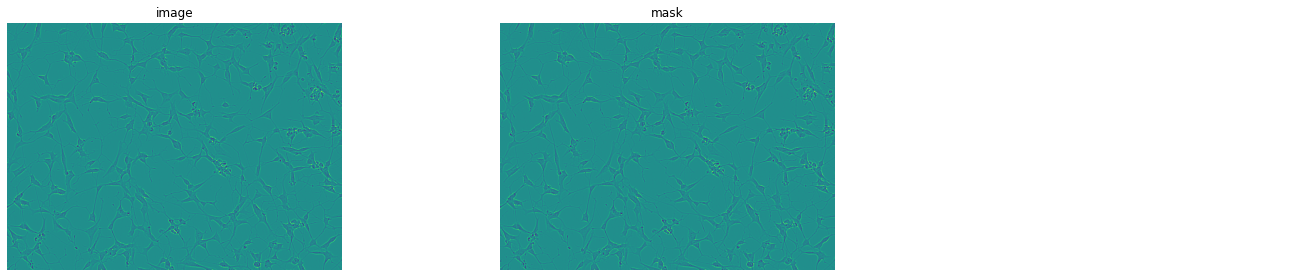

In [5]:
def plot_example(img_path):
    mask_path = img_path.replace('img','masks')
    flow_path = img_path.replace('img','flows')
    img = tifffile.imread(img_path)
    masks = tifffile.imread(mask_path)
    flows = tifffile.imread(flow_path)

    plt.figure(figsize=(25,10))
    plt.subplot(2,3,1)
    plt.axis('off')
    plt.imshow(img)
    plt.title('image')
    plt.subplot(2,3,2)
    plt.axis('off')
    plt.imshow(masks)
    plt.title('mask')
    for k in range(4):
        plt.subplot(2,3,3+k)
        plt.axis('off')
        plt.imshow(flows[k])
        plt.title(f'flow {k}')
    plt.show()
    
root = os.path.join(RAW_DATA,'cellpose-with-livecell','images/') 
sample_paths = os.listdir(root)
# sample_paths = [x for x in sample_paths if 'img' in x]
random.shuffle(sample_paths)
for k in range(5):
    img_path = sample_paths[k]
    print(img_path)
    plot_example(root+img_path)

## Train

In [16]:
model_to_load = 'cyto2' ## cyto, cyto2, nuclei
number_of_epochs = 500  ## Train more epochs for better results
batch_size = 8
initial_learning_rate = 0.0001
Training_channel = 0 # For grayscale
Second_training_channel= 0 
train_folder = f'/tmp/livecell/train'
test_folder = f'/tmp/livecell/val'

In [7]:
!rm -rf '/home/ubuntu/kaggle-sartorius/data/raw/cellpose-with-livecell/pretrain/train'
!rm -rf '/home/ubuntu/kaggle-sartorius/data/raw/cellpose-with-livecell/pretrain/val'

In [8]:
os.makedirs(os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','train'))
os.makedirs(os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','val'))
val_set_images_interim = random.sample(population=set(os.listdir(root)),
                 k=round(len(os.listdir(root))*0.2))
train_set_images_interim = list(set(os.listdir(root))-set(val_set_images_interim))
assert len(train_set_images_interim)+len(val_set_images_interim)==len(set(os.listdir(root)))

In [9]:
val_set_images  = [i for i in val_set_images_interim if 'shsy5y' in i]
train_set_images = [i for i in train_set_images_interim if 'shsy5y' in i]

In [10]:
dataset = {'train':train_set_images,'val':val_set_images}

In [11]:
import shutil
for data_type,data in dataset.items():
    print(f"Copying {data_type} data")
    for file_name in tqdm(data,total=len(data)):
        img_src_file_path = os.path.join(RAW_DATA,'cellpose-with-livecell','images', file_name)
        img_dst_file_path = os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain',data_type, f"{file_name.split('.')[0]}_img.tif")
        mask_src_file_path = os.path.join(RAW_DATA,'cellpose-with-livecell','masks', file_name)
        mask_dst_file_path = os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain',data_type, f"{file_name.split('.')[0]}_masks.tif")
        if os.path.isfile(img_src_file_path):
            shutil.copy(img_src_file_path, img_dst_file_path)
        if os.path.isfile(mask_src_file_path):
            shutil.copy(mask_src_file_path, mask_dst_file_path)
    print(f"Copying {data_type} data...DONE")
assert len(os.listdir(os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','train')))/2 == len(train_set_images)
assert len(os.listdir(os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','val')))/2 == len(val_set_images)

Copying train data


  0%|          | 0/357 [00:00<?, ?it/s]

Copying train data...DONE
Copying val data


  0%|          | 0/92 [00:00<?, ?it/s]

Copying val data...DONE


In [12]:
len(os.listdir(os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','train')))

714

In [13]:
!rm -rf /tmp/livecell/

In [14]:
model_to_load = '/home/ubuntu/kaggle-sartorius/notebooks/testing-model'

In [15]:
!mkdir -p /tmp/livecell/
!cp -r /home/ubuntu/kaggle-sartorius/data/raw/cellpose-with-livecell/pretrain/* /tmp/livecell/

In [17]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

714
184


In [20]:
import cellpose

2021-12-30 07:31:30,592 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log


In [28]:
from cellpose import models
cp_model = models.Cellpose()

2021-12-30 07:37:19,501 [INFO] >>>> using CPU
2021-12-30 07:37:19,503 [INFO] WARNING: MKL version on torch not working/installed - CPU version will be slightly slower.
2021-12-30 07:37:19,503 [INFO] see https://pytorch.org/docs/stable/backends.html?highlight=mkl
2021-12-30 07:37:19,580 [INFO] Downloading: "https://www.cellpose.org/models/size_cytotorch_0.npy" to /home/ubuntu/kaggle-sartorius/models/size_cytotorch_0.npy



100%|██████████| 5.23k/5.23k [00:00<00:00, 9.36MB/s]


In [46]:
cp_model=models.CellposeModel(
    gpu=True,
    pretrained_model='/home/ubuntu/kaggle-sartorius/models/cytotorch_0',
    model_type='cyto',
    net_avg=True,
    torch=True,
    diam_mean=17.0,
    device=None,
    residual_on=True,
    style_on=True,
    concatenation=False,
    nchan=2,
    nclasses=3,
    omni=False,
)

2021-12-30 07:48:29,709 [INFO] >>cyto<< model set to be used
2021-12-30 07:48:29,717 [INFO] ** TORCH CUDA version installed and working. **
2021-12-30 07:48:29,719 [INFO] >>>> using GPU


In [47]:
os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','train')

'/home/ubuntu/kaggle-sartorius/data/raw/cellpose-with-livecell/pretrain/train'

In [48]:
cp_model.diam_mean

17.0

In [44]:
# cp_model.train(
#     train_data=os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','train'),
#     train_labels,
#     train_files=None,
#     test_data=os.path.join(RAW_DATA,'cellpose-with-livecell','pretrain','val'),
#     test_labels=None,
#     test_files=None,
#     channels=None,
#     normalize=True,
#     pretrained_model=None,
#     save_path=None,
#     save_every=100,
#     save_each=False,
#     learning_rate=0.2,
#     n_epochs=500,
#     momentum=0.9,
#     SGD=False,
#     weight_decay=1e-05,
#     batch_size=8,
#     rescale=False,
#     omni=False,
# )

In [51]:
torch.save(cp_model, './testing-model')
cp_model.pretrained_model

In [52]:
model_to_load = '/home/ubuntu/kaggle-sartorius/notebooks/testing-model'

In [53]:
!python -m cellpose \
            --train \
            --use_gpu \
            --fast_mode \
            --diameter 17 \
            --dir "$train_folder" \
            --test_dir "$test_folder" \
            --pretrained_model $model_to_load \
            --chan $Training_channel --chan2 $Second_training_channel \
            --n_epochs $number_of_epochs \
            --learning_rate 0.01 \
            --batch_size 4 \
            --save_every 50 \
            --img_filter img \
            --mask_filter masks

2021-12-30 07:54:56,275 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log
2021-12-30 07:54:58,128 [INFO] ** TORCH CUDA version installed and working. **
2021-12-30 07:54:58,128 [INFO] >>>> using GPU
2021-12-30 07:54:59,746 [INFO] >>>> pretrained model /home/ubuntu/kaggle-sartorius/notebooks/testing-model is being used
2021-12-30 07:54:59,746 [INFO] >>>> during training rescaling images to fixed diameter of 30.0 pixels
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/cellpose/__main__.py", line 436, in <module>
    main()
  File "/home/ubuntu/.local/lib/python3.8/site-packages/cellpose/__main__.py", line 396, in main
    model = models.CellposeModel(device=device,
  File "/home/ubuntu/.local/lib/python3.8/site-packages/cellpose/model

In [ ]:
!ls -lh /tmp/livecell/train/models

In [ ]:
!cp -r /tmp/livecell/train/models ./models/fold_{FOLD}/

## Inference 

Refer: https://www.kaggle.com/slawekbiel/cellpose-inference-307-lb

In [ ]:
glob.glob(f'models/fold_{FOLD}/*')[0]

In [ ]:
##----------Update this Manually
model_path = model_to_load

print(model_path)

In [ ]:
import sys
import numpy as np
from cellpose import models, io, plot
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import glob

USE_GPU_FOR_INFERENCE = True

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_files = glob.glob(f'/tmp/cellpose_train/val/*_img.tif')
print(len(test_files))
model = models.CellposeModel(gpu=USE_GPU_FOR_INFERENCE, pretrained_model=model_path)

ids, masks = [],[]
for fn in tqdm(test_files):
    id_ = fn.split('/')[-1].replace('_img.tif','')
    preds, flows, _ = model.eval(io.imread(fn), diameter=19, channels=[0,0], augment=True, resample=True)
    for i in range (1, preds.max() + 1):
        ids.append(id_)
        masks.append(rle_encode(preds == i))
FOLD = sys.argv[3]
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv(f'val_predictions_fold_{FOLD}.csv', index=False)

In [ ]:
%%writefile predict.py
import sys
import numpy as np
from cellpose import models, io, plot
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import glob

USE_GPU_FOR_INFERENCE = True

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_files = glob.glob(f'/tmp/cellpose_train/val/*_img.tif')
print(len(test_files))
model = models.CellposeModel(gpu=USE_GPU_FOR_INFERENCE, pretrained_model=sys.argv[1])

ids, masks = [],[]
for fn in tqdm(test_files):
    id_ = fn.split('/')[-1].replace('_img.tif','')
    preds, flows, _ = model.eval(io.imread(fn), diameter=19, channels=[0,0], augment=True, resample=True)
    for i in range (1, preds.max() + 1):
        ids.append(id_)
        masks.append(rle_encode(preds == i))
FOLD = sys.argv[3]
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv(f'val_predictions_fold_{FOLD}.csv', index=False)

In [ ]:
!python predict.py {model_path} /tmp/cellpose_train/val {FOLD}

## Plot

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import skimage
import skimage.segmentation
import matplotlib.pyplot as plt

In [ ]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

In [ ]:
width = 704
height = 520
shape = [height,width]

train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

cellpose_predictions = pd.read_csv(f'val_predictions_fold_{FOLD}.csv')
cellpose_predictions = cellpose_predictions.groupby('id').predicted.agg(list).reset_index()
df = pd.merge(train_df,cellpose_predictions,on='id')

print(df.shape)

df.sample(2)

In [ ]:
for i,row in df.iterrows():
    
    print(row.id)
    gt_masks = rles_to_mask(row.annotation, shape).astype(np.uint16)
    predicted_masks = rles_to_mask(row.predicted, shape).astype(np.uint16)
    
    gt_masks = (gt_masks>0).astype(int)*(gt_masks%5)
    predicted_masks = (predicted_masks>0).astype(int)*(predicted_masks%5)

    _, axs = plt.subplots(1, 2, figsize=(36, 18))
    axs = axs.flatten()
    axs[0].imshow(gt_masks)
    axs[1].imshow(predicted_masks)
    plt.show()
    
    if i==4: break

## Evaluate

In [ ]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [
        compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape)) 
            for truth, pred in tqdm(zip(truths, preds))
    ]
    
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrecision\tRecall")

    prec = []
    recalls = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        r = tps / (tps + fns)
        prec.append(p)
        recalls.append(r)
   
        if verbose:
            print("{:1.2f}\t{}\t{}\t{}\t{:1.3f}\t{:1.3f}".format(t, tps, fps, fns, p, r))

    if verbose:
        print("AP\t-\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return round(np.mean(prec),4)

In [ ]:
annotations = df.annotation.values
predictions = df.predicted.values

In [ ]:
iou_map(annotations,predictions,verbose=1)

## Tracking perf. 
### fold-2  
epochs=10, BS=8
iou=0.3543  
Epoch 9, Time 85.6s, Loss 0.5771, Loss Test 0.5457, LR 0.000  
----
epochs=50, BS=8
iou=0.3818  
Epoch 40, Time 313.2s, Loss 0.4704, Loss Test 0.4716, LR 0.0002
##### Increasing epochs 10-->50, increases IoU by 7.7%
##### Reducing BS from 8--->4 doesn't make any difference
